# Dataset Preparation & EDA

In [5]:
!pip install datasets pandas matplotlib seaborn


  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.6 MB 5.6 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.6 MB 4.9 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/11.6 MB 4.5 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/11.6 MB 3.7 MB/s eta 0:00:03
   ---------- ----------------------------- 3.1/11.6 MB 3.8 MB/s eta 0:00:03
   --------------- ------------------------ 4.5/11.6 MB 3.7 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.6 MB 3.8 MB/s eta 0:00:02
   ---------------------- ----------------- 6.6/11.6 MB 4.1 MB/s eta 0:00:02
   ------

In [6]:
#Load the MovieLens Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up clean plot styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Paths (modify these as needed)
ratings_path = "MoviesLense/ratings.csv"
movies_path = "MoviesLense/movies.csv"

# Load datasets
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Display basic info
print("Ratings Dataset:")
print(ratings.info())
print("\nMovies Dataset:")
print(movies.info())

# Display first few rows
print("\nSample Ratings Data:")
print(ratings.head())
print("\nSample Movies Data:")
print(movies.head())


Ratings Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None

Movies Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

Sample Ratings Data:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

Sample Movies Data:
   movieId                      

In [5]:
# Merge Datasets and Convert Timestamps

# Merge ratings with movie titles
movie_data = pd.merge(ratings, movies, on="movieId")

# Convert timestamp
movie_data['timestamp'] = pd.to_datetime(movie_data['timestamp'], unit='s')

# Preview merged dataset
movie_data.head()


,userId,movieId,rating,timestamp,title,genres
0,1,17,4.0,1999-12-03 19:24:37,Sense and Sensibility (1995),Drama|Romance
1,3,17,5.0,2004-05-13 21:53:37,Sense and Sensibility (1995),Drama|Romance
2,15,17,4.5,2010-11-15 21:57:51,Sense and Sensibility (1995),Drama|Romance
3,28,17,4.0,2000-06-20 15:10:29,Sense and Sensibility (1995),Drama|Romance
4,29,17,4.0,1996-10-11 17:48:31,Sense and Sensibility (1995),Drama|Romance


In [6]:
# Missing Values and Basic Stats
# Check for missing values
print(movie_data.isnull().sum())

# Summary statistics
print(movie_data.describe())

# Number of unique users and movies
num_users = movie_data['userId'].nunique()
num_movies = movie_data['movieId'].nunique()

print(f"Unique Users: {num_users}")
print(f"Unique Movies: {num_movies}")


userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64
             userId       movieId        rating                      timestamp
count  3.200020e+07  3.200020e+07  3.200020e+07                       32000204
mean   1.002785e+05  2.931861e+04  3.540396e+00  2010-05-30 17:39:59.573264640
min    1.000000e+00  1.000000e+00  5.000000e-01            1995-01-09 11:46:44
25%    5.005300e+04  1.233000e+03  3.000000e+00            2003-04-22 11:53:50
50%    1.002970e+05  3.452000e+03  3.500000e+00     2010-04-30 10:03:32.500000
75%    1.504510e+05  4.419900e+04  4.000000e+00  2017-08-19 15:59:05.249999872
max    2.009480e+05  2.927570e+05  5.000000e+00            2023-10-13 02:29:07
std    5.794905e+04  5.095816e+04  1.058986e+00                            NaN
Unique Users: 200948
Unique Movies: 84432


C:\Users\adnan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


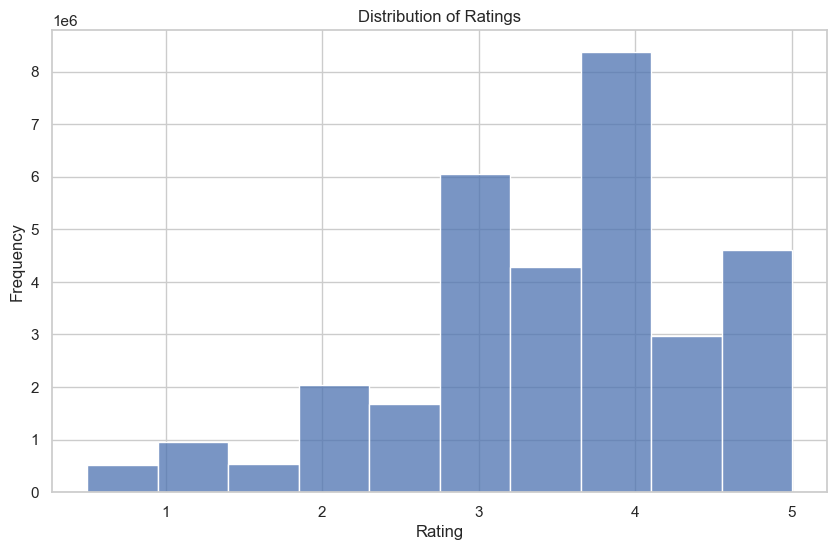

In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create directory for saving plots
os.makedirs("plots", exist_ok=True)

# Plot Rating Distribution
plt.figure()
sns.histplot(movie_data['rating'], bins=10, kde=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig("plots/rating_distribution.png")
plt.show()


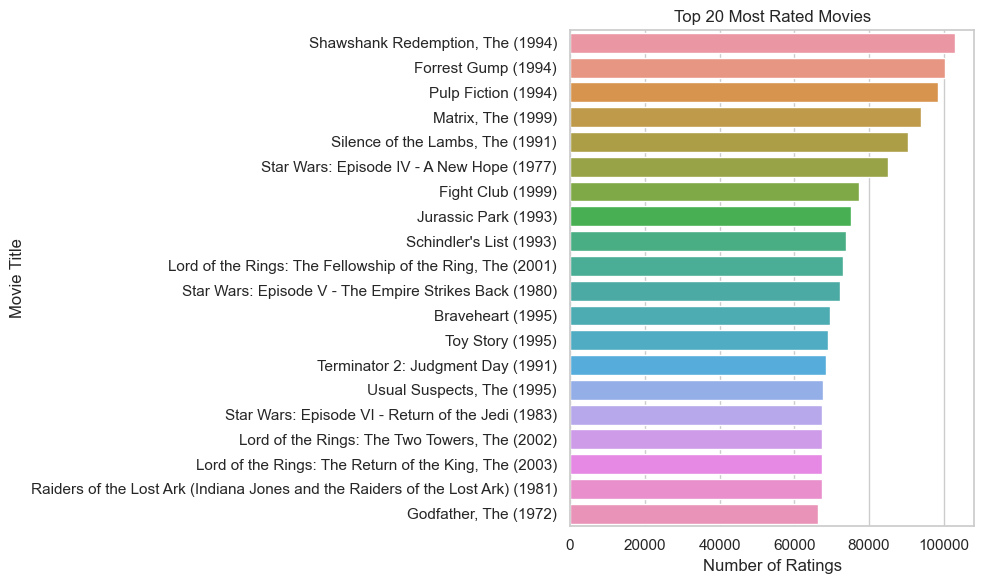

In [10]:
# Plot – Top 20 Most Rated Movies
top_movies = movie_data['title'].value_counts().head(20)

plt.figure()
sns.barplot(y=top_movies.index, x=top_movies.values)
plt.title("Top 20 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.savefig("plots/top_20_most_rated_movies.png")
plt.show()


In [17]:
#Extract and Encode Genres

#Each movie can have multiple genres (e.g., "Action|Adventure|Sci-Fi"). We’ll:

# 1.Split genres.
# 2.One-hot encode them for Content-Based Filtering.

#extract genre information
# Split genre strings into lists
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

#Create Genre One-Hot Encoding
# Get all unique genres
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(mlb.fit_transform(movies['genres']),
                            columns=mlb.classes_,
                            index=movies['movieId'])

# Combine with original movie info
movies_with_genres = pd.concat([movies[['movieId', 'title']], genre_matrix], axis=1)

# Preview encoded genre matrix
movies_with_genres.head()

#Merge Genre Data with Ratings
# Merge with ratings
# Merge genre info directly with ratings
merged_data = pd.merge(ratings, movies_with_genres, on="movieId")

# Optional: reorder columns for readability
cols = ['userId', 'movieId', 'title', 'rating'] + list(genre_matrix.columns)
merged_data = merged_data[cols]

# Preview
merged_data.head()



,userId,movieId,title,rating
0,1,17,Sense and Sensibility (1995),4.0
1,3,17,Sense and Sensibility (1995),5.0
2,15,17,Sense and Sensibility (1995),4.5
3,28,17,Sense and Sensibility (1995),4.0
4,29,17,Sense and Sensibility (1995),4.0


# Build a Content-Based Recommendation System


In [30]:
# Reload fresh movies.csv
movies = pd.read_csv("MoviesLense/movies.csv")

# Print the first few rows
print("Sample rows:")
print(movies.head(3))

# Print one specific genre entry
print("\nFirst genre entry (raw):", movies.loc[0, 'genres'])

# Split genre strings into lists
movies['genres'] = movies['genres'].fillna('').apply(lambda x: x.split('|'))

print("Split genres (first 3 rows):")
print(movies['genres'].head(3))


from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(
    mlb.fit_transform(movies['genres']),
    columns=mlb.classes_,
    index=movies.index
)

print("Genre matrix shape:", genre_matrix.shape)
print("Genres encoded:", genre_matrix.columns.tolist())


Sample rows:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

First genre entry (raw): Adventure|Animation|Children|Comedy|Fantasy
Split genres (first 3 rows):
0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
Name: genres, dtype: object
Genre matrix shape: (87585, 20)
Genres encoded: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [42]:
# Finalize Cosine Similarity Matrix
#Content-Based Similarity Between Movies (Genre-Only)
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

# STEP 1: Load clean movies.csv (~9742 rows)
movies = pd.read_csv("MoviesLense/movies.csv")
movies['genres'] = movies['genres'].fillna('').astype(str).apply(lambda x: x.split('|'))
movies = movies.drop_duplicates(subset='title').reset_index(drop=True)

# STEP 2: One-hot encode genres
mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(
    mlb.fit_transform(movies['genres']),
    columns=mlb.classes_,
    index=movies['title']
)

# STEP 3: Compute similarity
cosine_sim = cosine_similarity(genre_matrix.values)
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=genre_matrix.index,
    columns=genre_matrix.index
)

# STEP 4: Recommender function
def get_similar_movies(movie_title, top_n=5):
    if movie_title not in cosine_sim_df.columns:
        print(f"❌ Movie '{movie_title}' not found.")
        return []
    sim_scores = cosine_sim_df[movie_title].sort_values(ascending=False)
    return sim_scores.iloc[1:top_n+1]

# STEP 5: Test it
print("🎬 Similar to 'Toy Story (1995)':")
print(get_similar_movies("Toy Story (1995)", top_n=8))


🎬 Similar to 'Toy Story (1995)':
title
Adventures of Rocky and Bullwinkle, The (2000)    1.0
Emperor's New Groove, The (2000)                  1.0
Monsters, Inc. (2001)                             1.0
Tale of Despereaux, The (2008)                    1.0
Wild, The (2006)                                  1.0
Moana (2016)                                      1.0
Antz (1998)                                       1.0
Turbo (2013)                                      1.0
Name: Toy Story (1995), dtype: float64


# Collaborative Filtering

In [43]:
# Recommend movies to a target user based on ratings from similar users.


In [1]:
# Create User-Item Matrix + Similarity
# Collaborative Filtering with Surprise (SVD Model)

# 📦 Step 1: Install scikit-surprise (only run once if not installed)
# pip install scikit-surprise

# Step 1: Show your Jupyter Python path (to make sure we're installing in the correct environment)
import sys
print(sys.executable)


C:\Users\adnan\anaconda3\envs\movielens_env\python.exe


In [2]:
# 📌 Step 2: Imports

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

# 📂 Step 3: Load the ratings data (from MovieLens 25M)
ratings_df = pd.read_csv("MoviesLense/ratings.csv")  # 🔁 Update path if needed
print("✅ Ratings loaded:", ratings_df.shape)

# 🧠 Step 4: Prepare data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# 🎯 Step 5: Split into training and test sets
trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

# 🧠 Step 6: Build and train SVD model
model = SVD()
model.fit(trainset)

# 🎯 Step 7: Predict ratings on test set
predictions = model.test(testset)

# 🧪 Step 8: Evaluate RMSE
rmse = accuracy.rmse(predictions)
print("✅ RMSE:", rmse)

# 📊 Step 9: Function to get Top-N recommendations
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort and keep top N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=5)

# 📚 Step 10: Load movie titles to map movieId → title
movies_df = pd.read_csv("MoviesLense/movies.csv")
movie_lookup = dict(zip(movies_df['movieId'], movies_df['title']))

# 🎬 Step 11: Show top 5 recommendations for a user (e.g., userId = 1)
print("\n🎬 Top 5 recommendations for user 1:")
for movie_id, pred_rating in top_n[1]:
    movie_title = movie_lookup.get(movie_id, "Unknown Movie")
    print(f"{movie_title} → Predicted Rating: {pred_rating:.2f}")


NameError: name 'pd' is not defined